In [1]:
# 라이브러리들 호출

import os
from os.path import join

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# 모델 정의를 위한 라이브러리
from xgboost import XGBRegressor
from xgboost import plot_importance
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# sklearn.model_selection 라이브러리 안에 있는 GridSearchCV 클래스를 활용
from sklearn.model_selection import GridSearchCV

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)

In [2]:
# 캐글에서 다운 받은 데이터들 저장

root_path = os.getenv('HOME')+'/aiffel/kaggle/Predict_Future_Sales/data/'

items = pd.read_csv(root_path+'items.csv')
shops = pd.read_csv(root_path+'shops.csv')
cats = pd.read_csv(root_path+'item_categories.csv')
train = pd.read_csv(root_path+'sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv(root_path+'test.csv').set_index('ID')

In [3]:
# test 데이터 확인
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


## Outlier(이상치 확인)

-22.0 2169.0
-1.0 307980.0


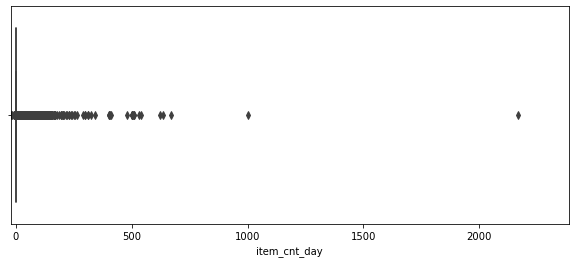

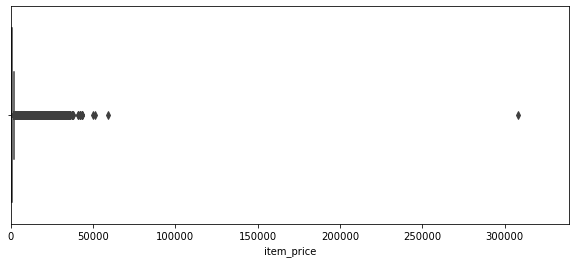

In [4]:
# 이상치에 대한 그래프 그리기
plt.figure(figsize=(10,4))
plt.xlim(train.item_cnt_day.min(), train.item_cnt_day.max()*1.1)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)


# 일별 품목별 판매량의 최소, 최대 값 출력
print(train.item_cnt_day.min(), train.item_cnt_day.max())

# 물품 가격의 최소, 최대 값 출력
print(train.item_price.min(), train.item_price.max())



In [5]:
# 이상치 제거

# 가격이 100000 이상인 데이터 제거
train = train[train.item_price<100000]

# 품목의 하루 판배량이 1001 이상인 데이터 제거
train = train[train.item_cnt_day<1001]

##### 위에서 가격이 0 아래인 값이 존재하는 데 이부분은 median을 이용해 처리해준다.

In [6]:
# 마이너스 가격 물품 있는지 확인
train[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [7]:
# 마이너스 가격인 데이터는 중앙 값으로 보정

# 같은 가게, 같은 물건, 같은 판매월, 0원 이상의 가격인 데이터에서 판매가격의 중앙 값을 보정 값으로 채택
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median
train.iloc[484683]

date              15.05.2013
date_block_num             4
shop_id                   32
item_id                 2973
item_price              1874
item_cnt_day               1
Name: 484683, dtype: object

##### 아래의 shop들은 동일하지만 이름의 표기가 조금 달라 2개로 나뉘어졌다고 한다. 이를 하나로 합친다.

In [8]:

# shop_id = 0과 57은 같은가게, shop_id = 0 => 57로 변경
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

# shop_id = 1과 58은 같은가게, shop_id = 1 => 58로 변경
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

# shop_id = 10과 11은 같은가게, shop_id = 10 => 11로 변경
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

print(shops[shops.shop_id==0].shop_name)
print(shops[shops.shop_id==57].shop_name,'\n')

print(shops[shops.shop_id==1].shop_name)
print(shops[shops.shop_id==58].shop_name,'\n')

print(shops[shops.shop_id==10].shop_name)
print(shops[shops.shop_id==11].shop_name,'\n')

0    !Якутск Орджоникидзе, 56 фран
Name: shop_name, dtype: object
57    Якутск Орджоникидзе, 56
Name: shop_name, dtype: object 

1    !Якутск ТЦ "Центральный" фран
Name: shop_name, dtype: object
58    Якутск ТЦ "Центральный"
Name: shop_name, dtype: object 

10    Жуковский ул. Чкалова 39м?
Name: shop_name, dtype: object
11    Жуковский ул. Чкалова 39м²
Name: shop_name, dtype: object 



### Shops/Cats/Items preprocessing

- 각 shop의 이름은 도시의 이름으로 시작한다.
- 각 카테고리의 이름 안에는 Main type과 sub type이 포함되어 있다.
위의 두가지를 특성으로 사용한다.

#### 1) shop preprocessing

In [9]:
# 가게 데이터 확인 => 이름안에 도시명이 포함됨을 확인
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [10]:
# 가게 이름에서 도시명을 뽑아 열로 만들어 주기
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [11]:
# 도시이름 앞에 '!' 붙어 있는 것 제거
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [12]:
# 도시 이름을 도시 코드(숫자형 데이터)로 변환
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops.head()

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


In [13]:
# 데이터 사용을 위해 가게명과 도시이름 등 문자를 뺀 숫자 데이터만 저장
shops = shops[['shop_id','city_code']]
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


#### 2) cats preprocessing('고양이' 전처리 아님 => '카테고리' 전처리 임)

In [14]:
# 카테고리 데이터를 살펴봅시다. => 잘보면 아이템 카테고리 이름에 대분류가 나와있음
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [15]:
# 대 분류를 나누기 (-(dash) 로 구분된 앞뒤를 나눕니다.) 
cats['split'] = cats['item_category_name'].str.split('-')
cats.head()

,item_category_name,item_category_id,split
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]"
1,Аксессуары - PS2,1,"[Аксессуары , PS2]"
2,Аксессуары - PS3,2,"[Аксессуары , PS3]"
3,Аксессуары - PS4,3,"[Аксессуары , PS4]"
4,Аксессуары - PSP,4,"[Аксессуары , PSP]"


In [16]:
# 앞에 대분류를 'type'이라는 열로 생성
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats.head()

,item_category_name,item_category_id,split,type
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары


In [17]:
# 각 type을 숫자 코드로 만들어 줌
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
cats.head()

,item_category_name,item_category_id,split,type,type_code
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,1
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,1


In [18]:
# 소분류(subtype)도 따로 나누어 열로 만듬
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats.head()

,item_category_name,item_category_id,split,type,type_code,subtype
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1,PS2
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1,PS3
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,1,PS4
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,1,PSP


In [19]:
# 소분류(subtype)에 대한 숫자 코드(subtype_code) 부여
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats.head()

,item_category_name,item_category_id,split,type,type_code,subtype,subtype_code
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1,PS2,9
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1,PS3,10
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,1,PS4,11
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,1,PSP,13


In [20]:
# 문자열 데이터 삭제하고 숫자만 남김
cats = cats[['item_category_id','type_code', 'subtype_code']]
cats.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [21]:
# 물건 데이터 살펴보기
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [22]:
# 문자열(물건 이름) 데이터 삭제
items.drop(['item_name'], axis=1, inplace=True)
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [23]:
# 그냥 데이터 갯수 확인하는 코드

# (Train data와 Test data 중 겹치는 물건 종류 갯수, Test Data의 물건 종류 갯수, Test Data 갯수)

# 별 의미 없어서 발표때는 지워버려도 될 듯?

len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

#### date_block_num / shop_id / item_id 별로 값을 할당해주기 위해 미리 빈공간을 만들어 준다.

In [24]:

# 월 단위(date_block_num)로 가게 별, 품목 별 표(matrix)를 기본 틀로 만들어줌

# 코드 앞 뒤에 ts ~, ~ ts : 코드 돌아가는 데 걸리는 시간을 체크

ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
print(matrix)
# data type casting
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
print(matrix)
time.time() - ts

          date_block_num  shop_id  item_id
0                      0       59    22154
1                      0       59     2552
2                      0       59     2554
3                      0       59     2555
4                      0       59     2564
...                  ...      ...      ...
10913799              33       21     7635
10913800              33       21     7638
10913801              33       21     7640
10913802              33       21     7632
10913803              33       21     7440

[10913804 rows x 3 columns]
          date_block_num  shop_id  item_id
114910                 0        2       19
117150                 0        2       27
120623                 0        2       28
118316                 0        2       29
114602                 0        2       32
...                  ...      ...      ...
10768788              33       59    22162
10768978              33       59    22163
10769644              33       59    22164
10771170              33 

5.765045404434204

#### 1. 발생이익

In [25]:
# train data 확인
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [26]:
# 매출(revenue) 열 추가
# 매출(revenue) = 물건 가격 * 일일 물건 판매량
train['revenue'] = train['item_price'] *  train['item_cnt_day']
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


#### 2. 동일한 날짜,가게,품목의 팔린 개수

In [27]:
# 우리가 최종적으로 구해야 타겟 항목인 '(가게별, 품목별)월간 판매량'(item_cnt_month) 내용 추가를 위한 코드

# 해당 달(date_block_num)에 가게 별(shop_id) 물건 품목(item_id)의 일 판매량을 다 더해줌(sum) = 월간 판매량
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.head()

item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              2       27               1.0
                       33               1.0
                       317              1.0
                       438              1.0
                       471              2.0

In [28]:
# 해댱 열 이름을 '월간 판매량(item_cnt_month)'으로 변경
group.columns = ['item_cnt_month']
group.head()

item_cnt_month
date_block_num shop_id item_id                
0              2       27                  1.0
                       33                  1.0
                       317                 1.0
                       438                 1.0
                       471                 2.0

In [29]:
# DataFrame에 index로 있던 항목(date_block_num, shop_id, item_id)들을 열(column)로 변경
group.reset_index(inplace=True)
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


In [30]:
# 해당 월에 판매 갯수가 없는 item에 대해서 NaN 값으로 채움
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,NaN
1,0,2,27,1.0
2,0,2,28,NaN
3,0,2,29,NaN
4,0,2,32,NaN


In [31]:
# NaN 값을 0으로 바꿔주고, 다른 값의 범위를 0~20으로 제한
print(matrix['item_cnt_month'].max(),matrix['item_cnt_month'].min())
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
print(time.time() - ts)
matrix.head()

1644.0 -22.0
8.23933744430542


,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


## test_data

In [32]:
# test 데이터 확인
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [33]:
# test 데이터에 date_block_num(월) 열 추가
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.head()

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [34]:
# 앞에서 만든 Matrix(월별 가게별 품목 별 판매량)과 Test 데이터를 붙임
# Test데이터의 월 판매량은 0으로 채움

matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month
11127999,34,45,18454,0.0
11128000,34,45,16188,0.0
11128001,34,45,15757,0.0
11128002,34,45,19648,0.0
11128003,34,45,969,0.0


In [35]:
# matrix와 shops 데이터를 결합 => city_code 열 추가

matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code
0,0,2,19,0.0,0
1,0,2,27,1.0,0
2,0,2,28,0.0,0
3,0,2,29,0.0,0
4,0,2,32,0.0,0


In [36]:
# matrix와 items 데이터를 결합 => item_category_id 열 추가

matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id
0,0,2,19,0.0,0,40
1,0,2,27,1.0,0,19
2,0,2,28,0.0,0,30
3,0,2,29,0.0,0,23
4,0,2,32,0.0,0,40


In [37]:
# matrix와 cats 데이터를 결합 => type_id, subtype_id 열 추가

matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10
2,0,2,28,0.0,0,30,8,55
3,0,2,29,0.0,0,23,5,16
4,0,2,32,0.0,0,40,11,4


In [38]:
# 각 열에 대한 데이터 타입(np.int8으로) 변환
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

In [39]:
# 품목별 이전(1달전, 2달전, 3달전, 6달전, 12달전 등) 데이터를 추가하는 함수 정의
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        
        # 실제로 해당 월("date_block_num") 보다 i만큼(1,2,3,6,12 개월) 값을 더한 열에 데이터를 추가하여
        # 그 데이터의 i만큼(1,2,3,6,12 개월) 이전 데이터를 삽입
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month') # 1달전, 2달전, 3달전, 6달전, 12달전 판매된 횟수
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN


In [40]:
# 데이터 확인
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
11127999,34,45,18454,0.0,20,55,13,2,1.0,0.0,0.0,0.0,NaN
11128000,34,45,16188,0.0,20,64,14,42,0.0,0.0,NaN,NaN,NaN
11128001,34,45,15757,0.0,20,55,13,2,0.0,0.0,0.0,0.0,0.0
11128002,34,45,19648,0.0,20,40,11,4,0.0,0.0,0.0,0.0,NaN
11128003,34,45,969,0.0,20,37,11,1,0.0,0.0,0.0,0.0,0.0


In [41]:
# 데이터 확인용 코드
matrix[(matrix.date_block_num==33) & (matrix.shop_id==45) & (matrix.item_id==18454)]

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
10847949,33,45,18454,1.0,20,55,13,2,0.0,0.0,0.0,0.0,NaN


#### 1달전 평균 판매량

In [42]:
# 매 월간 평균 판매량
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.head()

,item_cnt_month
,mean
date_block_num,
0,0.347168
1,0.324463
2,0.355469
3,0.275391
4,0.265137


In [43]:
# 위 데이터의 index를 열로 변경
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)
group.head()

,date_block_num,date_avg_item_cnt
0,0,0.347168
1,1,0.324463
2,2,0.355469
3,3,0.275391
4,4,0.265137


In [44]:
# matrix에 '월별 평균 판매량(date_avg_item_cnt)'를 추가
matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)

# matrix에 1개월 전 '월별 평균 판매량(date_avg_item_cnt)'를 추가
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt,date_avg_item_cnt_lag_1
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,0.347168,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,0.347168,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,0.347168,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,0.347168,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,0.347168,NaN


In [45]:
# matrix에 '월별 평균 판매량(date_avg_item_cnt)'를 삭제
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# 월별, 품목별 '월 물건 판매량('item_cnt_month')'의 평균 값을 1,2,3,6,12 개월 전 단위로 추가
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

#### 동일하게 가게별 1/2/3/6/12 달전 평균 판매량

In [47]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

17.862339735031128

#### 동일하게 아이템 카테고리 별 1달전 평균 판매량

In [48]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

5.908279657363892

#### 동일하게 같은 매장내에서 아이템 카테고리별 1달전 평균 판매량

In [49]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

6.336392879486084

####  같은 매장내에서 아이템 타입별 1달전 평균 판매량

In [50]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

6.42276406288147

#### 같은 매장내에서 아이템 서브 타입별 1달전 평균 판매량

In [51]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

6.506437301635742

#### 도시별 1달전 평균 판매량

In [52]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

6.4445319175720215

#### 도시-아이템 별 1달전 평균 판매량

In [53]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

10.087499380111694

#### 타입별 1달전 평균 판매량

In [54]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

6.723210334777832

#### 서브 타입별 1달전 평균 판매량

In [55]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

6.744843244552612

### Trend Features

In [56]:
# 전체기간에서 아이템 가격 평균 열 추가
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price'] 
group.reset_index(inplace=True)
group.head()

,item_id,item_avg_item_price
0,0,58.0
1,1,4490.0
2,2,58.0
3,3,79.0
4,4,58.0


In [57]:
# 위에 내용을 matrix에 추가하고
matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

# 같은 월별 아이템 가격 평균 값 추가
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']}) 
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)
group.head()

,date_block_num,item_id,date_item_avg_item_price
0,0,19,28.000000
1,0,27,2325.000000
2,0,28,549.000000
3,0,29,2397.500000
4,0,32,338.110349


In [58]:
# 위에 내용 matrix에 추가 및 확인
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,item_avg_item_price,date_item_avg_item_price
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.000,28.0
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1461.000,2324.0
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310.000,549.0
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1759.000,2398.0
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249.625,338.0


In [59]:
# 1,2,3,4,5,6 개월 전 월별 품목의 평균가격 열 추가
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags: # 해당 월에 이 아이템이 평균치를 봤을 때 가격이 낮은 편인지 높은 편인지
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row): # 이 중에 가장 최근 정보만 선택한다.
    for i in lags:
        if row['delta_price_lag_'+str(i)]: # 값이 있으면 Ture, 값이 없으면 False
            return row['delta_price_lag_'+str(i)] # 1,2,3,4,5,6 개월 전 데이터 중 가장 최신 데이터를 반환
    return 0


In [60]:
# 'delta_price_lag'(전체 가격 평균 대비 월 가격 평균 비율 - 1,2,3,4,5,6 개월 전 데이터 중 가장 최신 데이터) 열 추가
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# 계산에 사용된 열 삭제
# 오타 : feture => feature
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True) # 최근값 제외하고는 삭제

matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


#### 유사한 작업을 가게의 평균 수입과 해당 월 수입에 대해 실행한다.

In [61]:
# 월별, 가게별 매출 총액 
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

# 가게별 매출 총액의 평균
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

# 가게별 총 평균 매출과 가게별 월 배출 평균 비교
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

# 전달 1개월에 대하여 비교
matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


### special feat

In [62]:
# 월 column 추가
matrix['month'] = matrix['date_block_num'] % 12

In [63]:
# 해당 월의 일수 column 추가
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [64]:
cache = {}
# 해당 아이템이 해당 가게에서 최근에 팔렸던게 최근 몇달전 인지
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():
    key = str(row.item_id)+' '+str(row.shop_id)
    # cache에 key(물건id + 가게id) 값이 비어 있고
    if key not in cache:
        # 월 물건 판매량이 0이 아니면
        if row.item_cnt_month!=0:
            # 월 block 값을 추가
            cache[key] = row.date_block_num
    
    # key(물건id + 가게id) 값이 있으면
    else:
        # last_date_block_num에 해당하는 월_blk 추가
        last_date_block_num = cache[key]
        # 'item_shop_last_sale'(가장 최근에 몇 개월 전에 팔렸는지)
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num

# 결론적으로 matrix에 'item_shop_last_sale'을 추가하여 가장 최근에 팔린 것이 몇 개월 전 인지 추가
# 1번 팔리거나 안팔린 경우, -1 값으로 들어감
        
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31,-1
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31,-1
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31,-1
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31,-1
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31,-1


In [65]:
# 위는 각 가게별 여기서는 가게 전체에 대해서 해당 아이템이 최근 몇달전에 팔렸는지 확인
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():
    
    key = row.item_id
    # 캐시에 key(물건 id)가 들어있으면(판매된 적이 있으면,)
    if key not in cache:
        # 물건의 월 판매량이 0이 아니면
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num
            
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31,-1,-1
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31,-1,-1
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31,-1,-1
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31,-1,-1
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31,-1,-1


In [66]:
# 각 물건이 첫 판매 월로 부터 얼마나 되었는지

ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

0.8523659706115723

### Final preparations

In [67]:
# 처음 시작 12달은 데이터 제거(이전 12달치가 없어서 lag 값이 NaN이 됨)
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

0.4209122657775879

In [68]:
# matrix 공간에 NaN 값을 0으로 채워줌

ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

1.029712438583374

In [69]:
# matrix의 열 확인
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [70]:
# matrix 확인
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 40 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   city_code                             int8   
 5   item_category_id                      int8   
 6   type_code                             int8   
 7   subtype_code                          int8   
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_6                  float16
 12  item_cnt_month_lag_12                 float16
 13  date_avg_item_cnt_lag_1               float16
 14  date_item_avg_item_cnt_lag_1          float16
 15  date_ite

In [71]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

### LGBMRegressor 모델 적용

In [72]:
data = pd.read_pickle('data.pkl')

In [73]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [74]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [75]:
del data
gc.collect();

# 파라미터 설정을 위한 그리드 서치

In [76]:
# 그리드 서치 함수 작성

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSE')

    return results

In [77]:
# 위에서 정의한 함수 돌리기


# 1차 시도
param_grid = {
    'n_estimators': [50],
    'max_depth': [1],
}

random_state=2020

model = LGBMRegressor(random_state=random_state)

In [78]:
# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=1, n_estimators=50 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... max_depth=1, n_estimators=50, total=   4.6s
[CV] max_depth=1, n_estimators=50 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] ..................... max_depth=1, n_estimators=50, total=   4.6s
[CV] max_depth=1, n_estimators=50 ....................................
[CV] ..................... max_depth=1, n_estimators=50, total=   4.6s
[CV] max_depth=1, n_estimators=50 ....................................
[CV] ..................... max_depth=1, n_estimators=50, total=   4.6s
[CV] max_depth=1, n_estimators=50 ....................................
[CV] ..................... max_depth=1, n_estimators=50, total=   4.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.2s finished


,max_depth,n_estimators,score,RMSE
0,1,50,-0.87718,0.936579


In [79]:
# 2차 시도
param_grid = {
    'n_estimators': [100],
    'max_depth': [1],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=1, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... max_depth=1, n_estimators=100, total=   6.9s
[CV] max_depth=1, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


[CV] .................... max_depth=1, n_estimators=100, total=   7.0s
[CV] max_depth=1, n_estimators=100 ...................................
[CV] .................... max_depth=1, n_estimators=100, total=   7.0s
[CV] max_depth=1, n_estimators=100 ...................................
[CV] .................... max_depth=1, n_estimators=100, total=   7.1s
[CV] max_depth=1, n_estimators=100 ...................................
[CV] .................... max_depth=1, n_estimators=100, total=   7.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.4s finished


,max_depth,n_estimators,score,RMSE
0,1,100,-0.841008,0.917065


In [80]:
# 3차 시도
param_grid = {
    'n_estimators': [150],
    'max_depth': [1],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=1, n_estimators=150 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... max_depth=1, n_estimators=150, total=   9.7s
[CV] max_depth=1, n_estimators=150 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s


[CV] .................... max_depth=1, n_estimators=150, total=   9.6s
[CV] max_depth=1, n_estimators=150 ...................................
[CV] .................... max_depth=1, n_estimators=150, total=  10.0s
[CV] max_depth=1, n_estimators=150 ...................................
[CV] .................... max_depth=1, n_estimators=150, total=  11.1s
[CV] max_depth=1, n_estimators=150 ...................................
[CV] .................... max_depth=1, n_estimators=150, total=  10.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   51.1s finished


,max_depth,n_estimators,score,RMSE
0,1,150,-0.833526,0.912976


In [81]:
# 4차 시도
param_grid = {
    'n_estimators': [200],
    'max_depth': [1],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=1, n_estimators=200 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... max_depth=1, n_estimators=200, total=  12.3s
[CV] max_depth=1, n_estimators=200 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s remaining:    0.0s


[CV] .................... max_depth=1, n_estimators=200, total=  13.3s
[CV] max_depth=1, n_estimators=200 ...................................
[CV] .................... max_depth=1, n_estimators=200, total=  13.2s
[CV] max_depth=1, n_estimators=200 ...................................
[CV] .................... max_depth=1, n_estimators=200, total=  13.0s
[CV] max_depth=1, n_estimators=200 ...................................
[CV] .................... max_depth=1, n_estimators=200, total=  13.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


,max_depth,n_estimators,score,RMSE
0,1,200,-0.830829,0.911498


In [87]:
# 5차 시도
param_grid = {
    'n_estimators': [250],
    'max_depth': [1],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=1, n_estimators=250 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... max_depth=1, n_estimators=250, total=  13.9s
[CV] max_depth=1, n_estimators=250 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.9s remaining:    0.0s


[CV] .................... max_depth=1, n_estimators=250, total=  14.2s
[CV] max_depth=1, n_estimators=250 ...................................
[CV] .................... max_depth=1, n_estimators=250, total=  14.8s
[CV] max_depth=1, n_estimators=250 ...................................
[CV] .................... max_depth=1, n_estimators=250, total=  15.4s
[CV] max_depth=1, n_estimators=250 ...................................
[CV] .................... max_depth=1, n_estimators=250, total=  16.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished


,max_depth,n_estimators,score,RMSE
0,1,250,-0.829399,0.910714


In [88]:
# 6차 시도
param_grid = {
    'n_estimators': [300],
    'max_depth': [1],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=1, n_estimators=300 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... max_depth=1, n_estimators=300, total=  16.5s
[CV] max_depth=1, n_estimators=300 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.5s remaining:    0.0s


[CV] .................... max_depth=1, n_estimators=300, total=  18.1s
[CV] max_depth=1, n_estimators=300 ...................................
[CV] .................... max_depth=1, n_estimators=300, total=  17.8s
[CV] max_depth=1, n_estimators=300 ...................................
[CV] .................... max_depth=1, n_estimators=300, total=  18.5s
[CV] max_depth=1, n_estimators=300 ...................................
[CV] .................... max_depth=1, n_estimators=300, total=  18.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min finished


,max_depth,n_estimators,score,RMSE
0,1,300,-0.828055,0.909975


In [89]:
# 7차 시도
param_grid = {
    'n_estimators': [350],
    'max_depth': [1],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=1, n_estimators=350 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... max_depth=1, n_estimators=350, total=  19.1s
[CV] max_depth=1, n_estimators=350 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.1s remaining:    0.0s


[CV] .................... max_depth=1, n_estimators=350, total=  19.5s
[CV] max_depth=1, n_estimators=350 ...................................
[CV] .................... max_depth=1, n_estimators=350, total=  20.1s
[CV] max_depth=1, n_estimators=350 ...................................
[CV] .................... max_depth=1, n_estimators=350, total=  21.0s
[CV] max_depth=1, n_estimators=350 ...................................
[CV] .................... max_depth=1, n_estimators=350, total=  20.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished


,max_depth,n_estimators,score,RMSE
0,1,350,-0.827159,0.909483


In [90]:
# 8차 시도
param_grid = {
    'n_estimators': [400],
    'max_depth': [1],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=1, n_estimators=400 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... max_depth=1, n_estimators=400, total=  23.0s
[CV] max_depth=1, n_estimators=400 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.1s remaining:    0.0s


[CV] .................... max_depth=1, n_estimators=400, total=  23.7s
[CV] max_depth=1, n_estimators=400 ...................................
[CV] .................... max_depth=1, n_estimators=400, total=  23.5s
[CV] max_depth=1, n_estimators=400 ...................................
[CV] .................... max_depth=1, n_estimators=400, total=  23.5s
[CV] max_depth=1, n_estimators=400 ...................................
[CV] .................... max_depth=1, n_estimators=400, total=  23.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished


,max_depth,n_estimators,score,RMSE
0,1,400,-0.826316,0.909019


In [91]:
# 9차 시도
param_grid = {
    'n_estimators': [450],
    'max_depth': [1],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=1, n_estimators=450 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... max_depth=1, n_estimators=450, total=  26.0s
[CV] max_depth=1, n_estimators=450 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.0s remaining:    0.0s


[CV] .................... max_depth=1, n_estimators=450, total=  30.4s
[CV] max_depth=1, n_estimators=450 ...................................
[CV] .................... max_depth=1, n_estimators=450, total=  29.7s
[CV] max_depth=1, n_estimators=450 ...................................
[CV] .................... max_depth=1, n_estimators=450, total=  28.5s
[CV] max_depth=1, n_estimators=450 ...................................
[CV] .................... max_depth=1, n_estimators=450, total=  29.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min finished


,max_depth,n_estimators,score,RMSE
0,1,450,-0.825696,0.908678


In [92]:
# 10차 시도
param_grid = {
    'n_estimators': [500],
    'max_depth': [1],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=1, n_estimators=500 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... max_depth=1, n_estimators=500, total=  31.8s
[CV] max_depth=1, n_estimators=500 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.8s remaining:    0.0s


[CV] .................... max_depth=1, n_estimators=500, total=  35.5s
[CV] max_depth=1, n_estimators=500 ...................................
[CV] .................... max_depth=1, n_estimators=500, total=  31.2s
[CV] max_depth=1, n_estimators=500 ...................................
[CV] .................... max_depth=1, n_estimators=500, total=  30.3s
[CV] max_depth=1, n_estimators=500 ...................................
[CV] .................... max_depth=1, n_estimators=500, total=  30.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.7min finished


,max_depth,n_estimators,score,RMSE
0,1,500,-0.825115,0.908359


In [93]:
# 11차 시도
param_grid = {
    'n_estimators': [500],
    'max_depth': [10],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=10, n_estimators=500 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... max_depth=10, n_estimators=500, total=  50.8s
[CV] max_depth=10, n_estimators=500 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.8s remaining:    0.0s


[CV] ................... max_depth=10, n_estimators=500, total=  51.9s
[CV] max_depth=10, n_estimators=500 ..................................
[CV] ................... max_depth=10, n_estimators=500, total=  52.8s
[CV] max_depth=10, n_estimators=500 ..................................
[CV] ................... max_depth=10, n_estimators=500, total=  50.6s
[CV] max_depth=10, n_estimators=500 ..................................
[CV] ................... max_depth=10, n_estimators=500, total= 1.0min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min finished


,max_depth,n_estimators,score,RMSE
0,10,500,-0.711206,0.84333


In [94]:
# 12차 시도
param_grid = {
    'n_estimators': [500],
    'max_depth': [20],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=20, n_estimators=500 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... max_depth=20, n_estimators=500, total=  51.3s
[CV] max_depth=20, n_estimators=500 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.3s remaining:    0.0s


[CV] ................... max_depth=20, n_estimators=500, total=  55.1s
[CV] max_depth=20, n_estimators=500 ..................................
[CV] ................... max_depth=20, n_estimators=500, total=  53.1s
[CV] max_depth=20, n_estimators=500 ..................................
[CV] ................... max_depth=20, n_estimators=500, total=  52.7s
[CV] max_depth=20, n_estimators=500 ..................................
[CV] ................... max_depth=20, n_estimators=500, total=  50.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min finished


,max_depth,n_estimators,score,RMSE
0,20,500,-0.709029,0.842039


In [95]:
# 13차 시도 => 'max_depth' = 20 때 보다 RMSE 값 증가
param_grid = {
    'n_estimators': [500],
    'max_depth': [25],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=25, n_estimators=500 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... max_depth=25, n_estimators=500, total=  51.3s
[CV] max_depth=25, n_estimators=500 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.3s remaining:    0.0s


[CV] ................... max_depth=25, n_estimators=500, total=  50.6s
[CV] max_depth=25, n_estimators=500 ..................................
[CV] ................... max_depth=25, n_estimators=500, total=  51.2s
[CV] max_depth=25, n_estimators=500 ..................................
[CV] ................... max_depth=25, n_estimators=500, total=  49.9s
[CV] max_depth=25, n_estimators=500 ..................................
[CV] ................... max_depth=25, n_estimators=500, total=  52.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.3min finished


,max_depth,n_estimators,score,RMSE
0,25,500,-0.709186,0.842132


In [96]:
# 14차 시도 => 'max_depth' = 20 때 보다 RMSE 값 증가
param_grid = {
    'n_estimators': [500],
    'max_depth': [15],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=15, n_estimators=500 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... max_depth=15, n_estimators=500, total=  49.7s
[CV] max_depth=15, n_estimators=500 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.7s remaining:    0.0s


[CV] ................... max_depth=15, n_estimators=500, total=  52.0s
[CV] max_depth=15, n_estimators=500 ..................................
[CV] ................... max_depth=15, n_estimators=500, total=  54.5s
[CV] max_depth=15, n_estimators=500 ..................................
[CV] ................... max_depth=15, n_estimators=500, total=  53.8s
[CV] max_depth=15, n_estimators=500 ..................................
[CV] ................... max_depth=15, n_estimators=500, total=  57.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min finished


,max_depth,n_estimators,score,RMSE
0,15,500,-0.710091,0.842669


In [97]:
# 15차 시도 => 'max_depth' = 20 때 보다 RMSE 값 동일
param_grid = {
    'n_estimators': [500],
    'max_depth': [22],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=22, n_estimators=500 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... max_depth=22, n_estimators=500, total= 1.1min
[CV] max_depth=22, n_estimators=500 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] ................... max_depth=22, n_estimators=500, total=  58.8s
[CV] max_depth=22, n_estimators=500 ..................................
[CV] ................... max_depth=22, n_estimators=500, total=  58.9s
[CV] max_depth=22, n_estimators=500 ..................................
[CV] ................... max_depth=22, n_estimators=500, total=  55.6s
[CV] max_depth=22, n_estimators=500 ..................................
[CV] ................... max_depth=22, n_estimators=500, total=  55.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.9min finished


,max_depth,n_estimators,score,RMSE
0,22,500,-0.709029,0.842039


In [98]:
# 16차 시도 => 'max_depth' = 20,22 때 보다 RMSE 값 증가
param_grid = {
    'n_estimators': [500],
    'max_depth': [21],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=21, n_estimators=500 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... max_depth=21, n_estimators=500, total= 1.0min
[CV] max_depth=21, n_estimators=500 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV] ................... max_depth=21, n_estimators=500, total=  58.1s
[CV] max_depth=21, n_estimators=500 ..................................
[CV] ................... max_depth=21, n_estimators=500, total=  58.1s
[CV] max_depth=21, n_estimators=500 ..................................
[CV] ................... max_depth=21, n_estimators=500, total=  58.6s
[CV] max_depth=21, n_estimators=500 ..................................
[CV] ................... max_depth=21, n_estimators=500, total=  57.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.9min finished


,max_depth,n_estimators,score,RMSE
0,21,500,-0.709048,0.84205


In [99]:
# 17차 시도 => 'max_depth' = 20,22 때와 RMSE 값 동일
param_grid = {
    'n_estimators': [500],
    'max_depth': [23],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=23, n_estimators=500 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... max_depth=23, n_estimators=500, total=  54.3s
[CV] max_depth=23, n_estimators=500 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.4s remaining:    0.0s


[CV] ................... max_depth=23, n_estimators=500, total=  48.7s
[CV] max_depth=23, n_estimators=500 ..................................
[CV] ................... max_depth=23, n_estimators=500, total=  49.8s
[CV] max_depth=23, n_estimators=500 ..................................
[CV] ................... max_depth=23, n_estimators=500, total=  50.3s
[CV] max_depth=23, n_estimators=500 ..................................
[CV] ................... max_depth=23, n_estimators=500, total=  55.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.3min finished


,max_depth,n_estimators,score,RMSE
0,23,500,-0.709029,0.842039


In [100]:
# 18차 시도 => 'max_depth' = 20, 22, 23 때보다 RMSE 값 증가
param_grid = {
    'n_estimators': [500],
    'max_depth': [19],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=19, n_estimators=500 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... max_depth=19, n_estimators=500, total=  54.9s
[CV] max_depth=19, n_estimators=500 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.9s remaining:    0.0s


[CV] ................... max_depth=19, n_estimators=500, total=  52.1s
[CV] max_depth=19, n_estimators=500 ..................................
[CV] ................... max_depth=19, n_estimators=500, total=  53.4s
[CV] max_depth=19, n_estimators=500 ..................................
[CV] ................... max_depth=19, n_estimators=500, total= 1.0min
[CV] max_depth=19, n_estimators=500 ..................................
[CV] ................... max_depth=19, n_estimators=500, total=  53.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.6min finished


,max_depth,n_estimators,score,RMSE
0,19,500,-0.709044,0.842048


In [101]:
# 19차 시도 => 'max_depth' = 20, 22, 23와 RMSE 값 동일
param_grid = {
    'n_estimators': [500],
    'max_depth': [24],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=24, n_estimators=500 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... max_depth=24, n_estimators=500, total=  51.8s
[CV] max_depth=24, n_estimators=500 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.8s remaining:    0.0s


[CV] ................... max_depth=24, n_estimators=500, total=  47.3s
[CV] max_depth=24, n_estimators=500 ..................................
[CV] ................... max_depth=24, n_estimators=500, total=  47.6s
[CV] max_depth=24, n_estimators=500 ..................................
[CV] ................... max_depth=24, n_estimators=500, total=  46.4s
[CV] max_depth=24, n_estimators=500 ..................................
[CV] ................... max_depth=24, n_estimators=500, total=  49.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.0min finished


,max_depth,n_estimators,score,RMSE
0,24,500,-0.709029,0.842039


=> 'max_depth' = 20, 22, 23, 24일 때, RMSE 값이 동일하므로 중간 값인 22 사용

In [103]:
# 20차 시도 => 'max_depth' = 20, 22, 23와 RMSE 값 동일
param_grid = {
    'n_estimators': [600],
    'max_depth': [22],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=22, n_estimators=600 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... max_depth=22, n_estimators=600, total= 1.1min
[CV] max_depth=22, n_estimators=600 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] ................... max_depth=22, n_estimators=600, total= 1.2min
[CV] max_depth=22, n_estimators=600 ..................................
[CV] ................... max_depth=22, n_estimators=600, total= 1.1min
[CV] max_depth=22, n_estimators=600 ..................................
[CV] ................... max_depth=22, n_estimators=600, total=  59.1s
[CV] max_depth=22, n_estimators=600 ..................................
[CV] ................... max_depth=22, n_estimators=600, total=  58.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.3min finished


,max_depth,n_estimators,score,RMSE
0,22,600,-0.708232,0.841565


In [104]:
# 20차 시도 => 'max_depth' = 20, 22, 23와 RMSE 값 동일
param_grid = {
    'n_estimators': [800],
    'max_depth': [22],
}

# 그리드 서치 함수 실행
my_GridSearch(model, X_train, Y_train, param_grid, verbose=2, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_depth=22, n_estimators=800 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... max_depth=22, n_estimators=800, total= 1.4min
[CV] max_depth=22, n_estimators=800 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV] ................... max_depth=22, n_estimators=800, total= 1.4min
[CV] max_depth=22, n_estimators=800 ..................................
[CV] ................... max_depth=22, n_estimators=800, total= 1.3min
[CV] max_depth=22, n_estimators=800 ..................................
[CV] ................... max_depth=22, n_estimators=800, total= 1.3min
[CV] max_depth=22, n_estimators=800 ..................................
[CV] ................... max_depth=22, n_estimators=800, total= 1.3min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.7min finished


,max_depth,n_estimators,score,RMSE
0,22,800,-0.705246,0.839789


In [111]:
# 파라미터 max_depth=22, n_estimators=400 적용

# ts = time.time()

# LGBMRegressor(random_state=random_state)

# model = LGBMRegressor(
#     max_depth=22,
#     n_estimators=400)

# model.fit(
#     X_train, 
#     Y_train, 
#     eval_metric="rmse", 
#     eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
#     verbose=True, 
#     early_stopping_rounds = 10)

# time.time() - ts

[1]	training's rmse: 1.13873	training's l2: 1.29671	valid_1's rmse: 1.09927	valid_1's l2: 1.2084
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 1.09682	training's l2: 1.20302	valid_1's rmse: 1.06876	valid_1's l2: 1.14224
[3]	training's rmse: 1.06125	training's l2: 1.12625	valid_1's rmse: 1.04306	valid_1's l2: 1.08797
[4]	training's rmse: 1.0312	training's l2: 1.06337	valid_1's rmse: 1.02123	valid_1's l2: 1.04292
[5]	training's rmse: 1.00579	training's l2: 1.01162	valid_1's rmse: 1.00381	valid_1's l2: 1.00763
[6]	training's rmse: 0.984329	training's l2: 0.968904	valid_1's rmse: 0.9894	valid_1's l2: 0.978912
[7]	training's rmse: 0.965806	training's l2: 0.93278	valid_1's rmse: 0.977192	valid_1's l2: 0.954904
[8]	training's rmse: 0.950226	training's l2: 0.902929	valid_1's rmse: 0.966966	valid_1's l2: 0.935023
[9]	training's rmse: 0.937201	training's l2: 0.878346	valid_1's rmse: 0.959137	valid_1's l2: 0.919944
[10]	training's rmse: 0.925657	training's l2: 

16.930855989456177

In [110]:
# 파라미터 max_depth=22, n_estimators=500 적용

# ts = time.time()

# LGBMRegressor(random_state=random_state)

# model = LGBMRegressor(
#     max_depth=22,
#     n_estimators=500)

# model.fit(
#     X_train, 
#     Y_train, 
#     eval_metric="rmse", 
#     eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
#     verbose=True, 
#     early_stopping_rounds = 10)

# time.time() - ts

[1]	training's rmse: 1.13873	training's l2: 1.29671	valid_1's rmse: 1.09927	valid_1's l2: 1.2084
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 1.09682	training's l2: 1.20302	valid_1's rmse: 1.06876	valid_1's l2: 1.14224
[3]	training's rmse: 1.06125	training's l2: 1.12625	valid_1's rmse: 1.04306	valid_1's l2: 1.08797
[4]	training's rmse: 1.0312	training's l2: 1.06337	valid_1's rmse: 1.02123	valid_1's l2: 1.04292
[5]	training's rmse: 1.00579	training's l2: 1.01162	valid_1's rmse: 1.00381	valid_1's l2: 1.00763
[6]	training's rmse: 0.984329	training's l2: 0.968904	valid_1's rmse: 0.9894	valid_1's l2: 0.978912
[7]	training's rmse: 0.965806	training's l2: 0.93278	valid_1's rmse: 0.977192	valid_1's l2: 0.954904
[8]	training's rmse: 0.950226	training's l2: 0.902929	valid_1's rmse: 0.966966	valid_1's l2: 0.935023
[9]	training's rmse: 0.937201	training's l2: 0.878346	valid_1's rmse: 0.959137	valid_1's l2: 0.919944
[10]	training's rmse: 0.925657	training's l2: 

16.24065113067627

In [109]:
# 파라미터 max_depth=22, n_estimators=600 적용

# ts = time.time()

# LGBMRegressor(random_state=random_state)

# model = LGBMRegressor(
#     max_depth=22,
#     n_estimators=600)

# model.fit(
#     X_train, 
#     Y_train, 
#     eval_metric="rmse", 
#     eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
#     verbose=True, 
#     early_stopping_rounds = 10)

# time.time() - ts

[1]	training's rmse: 1.13873	training's l2: 1.29671	valid_1's rmse: 1.09927	valid_1's l2: 1.2084
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 1.09682	training's l2: 1.20302	valid_1's rmse: 1.06876	valid_1's l2: 1.14224
[3]	training's rmse: 1.06125	training's l2: 1.12625	valid_1's rmse: 1.04306	valid_1's l2: 1.08797
[4]	training's rmse: 1.0312	training's l2: 1.06337	valid_1's rmse: 1.02123	valid_1's l2: 1.04292
[5]	training's rmse: 1.00579	training's l2: 1.01162	valid_1's rmse: 1.00381	valid_1's l2: 1.00763
[6]	training's rmse: 0.984329	training's l2: 0.968904	valid_1's rmse: 0.9894	valid_1's l2: 0.978912
[7]	training's rmse: 0.965806	training's l2: 0.93278	valid_1's rmse: 0.977192	valid_1's l2: 0.954904
[8]	training's rmse: 0.950226	training's l2: 0.902929	valid_1's rmse: 0.966966	valid_1's l2: 0.935023
[9]	training's rmse: 0.937201	training's l2: 0.878346	valid_1's rmse: 0.959137	valid_1's l2: 0.919944
[10]	training's rmse: 0.925657	training's l2: 

16.430241584777832

In [112]:
# 파라미터 max_depth=22, n_estimators=800 적용

ts = time.time()

LGBMRegressor(random_state=random_state)

model = LGBMRegressor(
    max_depth=22,
    n_estimators=800)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[1]	training's rmse: 1.13873	training's l2: 1.29671	valid_1's rmse: 1.09927	valid_1's l2: 1.2084
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 1.09682	training's l2: 1.20302	valid_1's rmse: 1.06876	valid_1's l2: 1.14224
[3]	training's rmse: 1.06125	training's l2: 1.12625	valid_1's rmse: 1.04306	valid_1's l2: 1.08797
[4]	training's rmse: 1.0312	training's l2: 1.06337	valid_1's rmse: 1.02123	valid_1's l2: 1.04292
[5]	training's rmse: 1.00579	training's l2: 1.01162	valid_1's rmse: 1.00381	valid_1's l2: 1.00763
[6]	training's rmse: 0.984329	training's l2: 0.968904	valid_1's rmse: 0.9894	valid_1's l2: 0.978912
[7]	training's rmse: 0.965806	training's l2: 0.93278	valid_1's rmse: 0.977192	valid_1's l2: 0.954904
[8]	training's rmse: 0.950226	training's l2: 0.902929	valid_1's rmse: 0.966966	valid_1's l2: 0.935023
[9]	training's rmse: 0.937201	training's l2: 0.878346	valid_1's rmse: 0.959137	valid_1's l2: 0.919944
[10]	training's rmse: 0.925657	training's l2: 

16.53034234046936

In [106]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('LGBM_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('LGBM_train.pickle', 'wb'))
pickle.dump(Y_test, open('LGBM_test.pickle', 'wb'))

# 코드 설명은 코드 중간중간 주석으로 처리하였습니다.

 - The end - 